# Nested ANOVA - one between factor
Reference: http://www.flutterbys.com.au/stats/tut/tut9.2b.html

In [70]:
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
import patsy

### Data loading

In [71]:
curdies = pd.read_csv('../datasets/curdies.csv')

curdies['SITE'] = ['{}{}'.format(curdies['SEASON'][j][0],curdies['SITE'][i]) for i, j in zip(curdies['SITE'].index, curdies['SEASON'].index)]
curdies['SEASON'] = pd.Categorical(curdies['SEASON'], ordered=False)
curdies['SITE'] = pd.Categorical(curdies['SITE'], ordered=False)

curdies

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,W1,0.647683,0.897100
1,WINTER,W1,6.096152,1.571317
2,WINTER,W1,1.310564,1.069953
3,WINTER,W1,1.725279,1.146080
4,WINTER,W1,1.459387,1.099114
5,WINTER,W1,1.057561,1.014090
6,WINTER,W2,1.016298,1.004050
7,WINTER,W2,16.196794,2.006122
8,WINTER,W2,1.168081,1.039605
9,WINTER,W2,1.024299,1.006020


In [72]:
curdies_agg = curdies.groupby(by=['SEASON', 'SITE'], as_index=False).mean()
curdies_agg

,SEASON,SITE,DUGESIA,S4DUGES
0,SUMMER,S4,0.419095,0.350821
1,SUMMER,S5,0.229086,0.180462
2,SUMMER,S6,0.194244,0.381122
3,SUMMER,W1,NaN,NaN
4,SUMMER,W2,NaN,NaN
5,SUMMER,W3,NaN,NaN
6,WINTER,S4,NaN,NaN
7,WINTER,S5,NaN,NaN
8,WINTER,S6,NaN,NaN
9,WINTER,W1,2.049437,1.132942


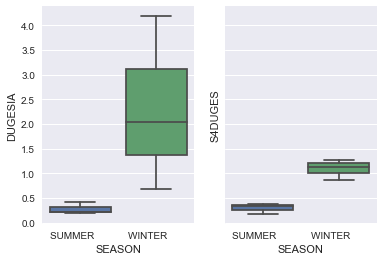

In [73]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

sns.boxplot(data=curdies_agg, x='SEASON', y='DUGESIA', ax=ax[0]) # variance is non heterogeneous
sns.boxplot(data=curdies_agg, x='SEASON', y='S4DUGES', ax=ax[1]) # the 4th root transformation helps at making the variance heterogeneous

## Fit hierarchical model
I will use the matrix parametrization

In [97]:
curdies_agg.dropna(axis=0, inplace=True)
curdies_agg.reset_index(inplace=True)
curdies_agg

,level_0,index,SEASON,SITE,DUGESIA,S4DUGES
0,0,0,SUMMER,S4,0.419095,0.350821
1,1,1,SUMMER,S5,0.229086,0.180462
2,2,2,SUMMER,S6,0.194244,0.381122
3,3,9,WINTER,W1,2.049437,1.132942
4,4,10,WINTER,W2,4.181908,1.271870
5,5,11,WINTER,W3,0.678206,0.867871


In [155]:
#X = patsy.dmatrix('SEASON', data=curdies_agg, return_type='dataframe')
#X # the size should be (n_sites, n_seasons), that is the number of row should be equal to the number of random factors
X = patsy.dmatrix('SEASON', data=curdies, return_type='dataframe')
X

,Intercept,SEASON[T.WINTER ]
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


In [156]:
Z = patsy.dmatrix('-1 + SITE', data=curdies, return_type='dataframe')
Z

,SITE[S4],SITE[S5],SITE[S6],SITE[W1],SITE[W2],SITE[W3]
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0


In [157]:
X.shape

(36, 2)

In [158]:
Z.shape

(36, 6)

In [160]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    sigma_X = pm.HalfCauchy('sigma_X', beta=10)
    beta_X = pm.Normal('beta_X', mu=0, sd=sigma_X, shape=X.shape[1])
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    sigma_Z = pm.HalfCauchy('sd_Z', beta=10)
    gamma_Z = pm.Normal('gamma_Z', mu=0, sd=sigma_Z, shape=Z.shape[1])
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=10) # unexplained variability
    
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=curdies.S4DUGES)
    
    trace = pm.sample(draws=5000, chains=4, step=pm.NUTS(), njobs=2, tune=1500)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sd_Z_log__, beta_X, sigma_X_log__]
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


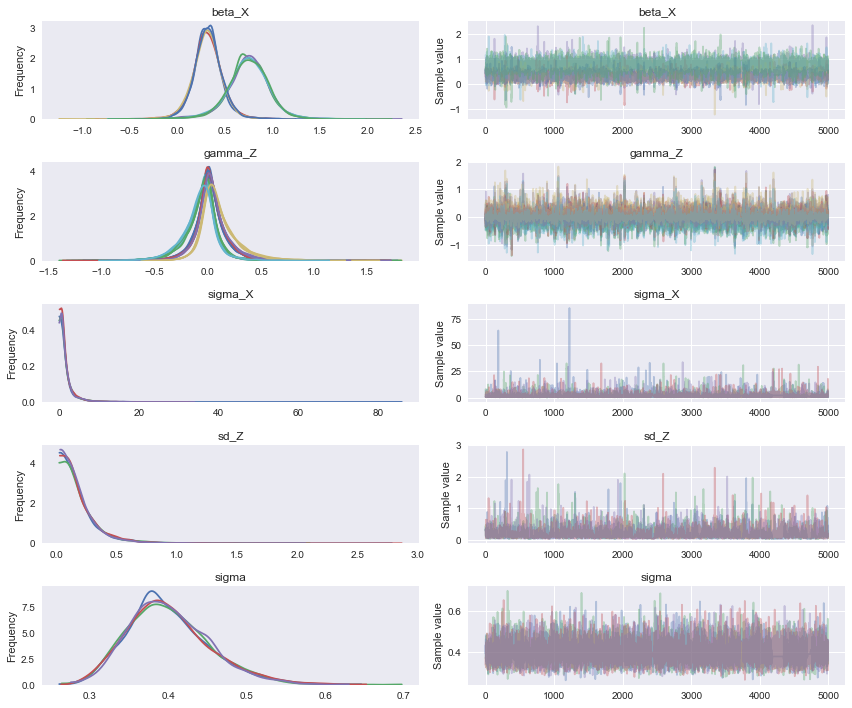

In [161]:
_ = pm.traceplot(trace)

In [162]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,0.314817,0.161509,0.002126,-0.006965,0.620764,5889.0,1.000716
beta_X__1,0.743905,0.231386,0.002875,0.285015,1.203920,6254.0,1.000007
gamma_Z__0,0.016430,0.161020,0.001797,-0.319666,0.336553,6905.0,1.000468
gamma_Z__1,-0.060529,0.165409,0.002185,-0.428910,0.233265,6347.0,1.000726
gamma_Z__2,0.028446,0.162322,0.001943,-0.274605,0.387788,6708.0,1.000873
gamma_Z__3,0.039516,0.176331,0.002287,-0.297110,0.404270,6316.0,1.000270
gamma_Z__4,0.103282,0.190442,0.002847,-0.204392,0.523509,4904.0,1.000323
gamma_Z__5,-0.078428,0.175092,0.002196,-0.450032,0.248014,6899.0,1.000061
sigma_X,1.877245,2.524271,0.027845,0.184393,5.903819,7062.0,1.000032
sd_Z,0.188409,0.174070,0.003749,0.019453,0.500974,2092.0,1.000511
